<a href="https://colab.research.google.com/github/sankalp120/premierleague_predictor/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving matches.csv to matches.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("libraries loaded ")


libraries loaded 


In [5]:


# Load dataset (make sure path matches where your CSV is saved)
data = pd.read_csv("matches.csv")

print(data.columns)
print(data.head())
print(data.shape)


Index(['Unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result',
       'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain',
       'formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist',
       'fk', 'pk', 'pkatt', 'season', 'team'],
      dtype='object')
   Unnamed: 0        date           time            comp        round  day  \
0           0  2020-09-21  20:15 (21:15)  Premier League  Matchweek 2  Mon   
1           2  2020-09-27  16:30 (17:30)  Premier League  Matchweek 3  Sun   
2           4  2020-10-03  17:30 (18:30)  Premier League  Matchweek 4  Sat   
3           5  2020-10-17  17:30 (18:30)  Premier League  Matchweek 5  Sat   
4           7  2020-10-24  12:30 (13:30)  Premier League  Matchweek 6  Sat   

  venue result  gf  ga  ...  match report  notes  sh  sot  dist fk pk pkatt  \
0  Away      W   3   1  ...  Match Report    NaN  13    8  21.1  2  1     1   
1  Home      L   2   5  ...  Match Report    NaN  16    5  19.8  1  0 

In [7]:
df = data.copy()

# Remove index column (not useful)
data = data.drop(columns=["Unnamed: 0"])

# Convert date to datetime
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# Standardize result encoding (W/L/D -> 1/0/2 or similar later)
data["result"] = data["result"].astype("category")

# Remove columns we do NOT need for modeling
cols_to_drop = ["time", "comp", "round", "day", "match report", "notes", "captain", "referee"]
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

# Rename columns to more meaningful predictive analytics names
data = data.rename(columns={
    "gf": "goals_for",
    "ga": "goals_against",
    "xg": "expected_goals",
    "xga": "expected_goals_against",
    "sh": "shots",
    "sot": "shots_on_target",
    "poss": "possession"
})

#   Drop rows with any missing key stats
data.dropna(subset=["goals_for","goals_against","team","opponent"], inplace=True)

#   Reset index after cleaning
data.reset_index(drop=True, inplace=True)

print("  Cleaning complete!")
print("➡ New shape:", data.shape)
print("\n🔍 Remaining Missing Data:")
print(data.isnull().sum())


✅ Cleaning complete!
➡ New shape: (4788, 19)

🔍 Remaining Missing Data:
date                         0
venue                        0
result                       0
goals_for                    0
goals_against                0
opponent                     0
expected_goals               0
expected_goals_against       0
possession                   0
attendance                1633
formation                    0
shots                        0
shots_on_target              0
dist                         2
fk                           0
pk                           0
pkatt                        0
season                       0
team                         0
dtype: int64


In [8]:

data = data.rename(columns={
    'gf': 'goals_for',
    'ga': 'goals_against',
    'xg': 'expected_goals',
    'xga': 'expected_goals_against',
    'poss': 'possession',
    'sh': 'shots',
    'sot': 'shots_on_target',
    'dist': 'avg_shot_distance'
})

print(data.columns)


Index(['date', 'venue', 'result', 'goals_for', 'goals_against', 'opponent',
       'expected_goals', 'expected_goals_against', 'possession', 'attendance',
       'formation', 'shots', 'shots_on_target', 'avg_shot_distance', 'fk',
       'pk', 'pkatt', 'season', 'team'],
      dtype='object')


Dataset shape: (4788, 19)

Match Result Counts:


,count
result,
W,1895
L,1820
D,1073


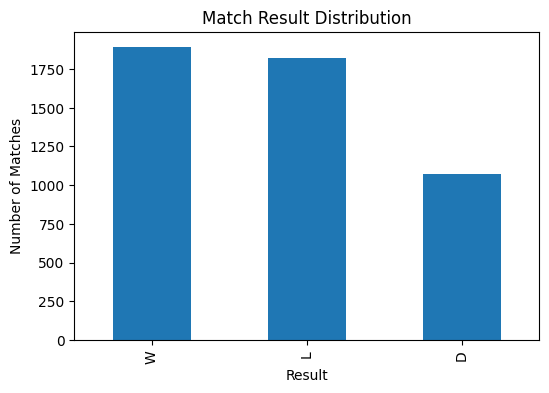

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Use cleaned+renamed dataset
df_eda = data.copy()

print("Dataset shape:", df_eda.shape)

# -------------------------
#  Match Result Distribution (W/D/L)
# -------------------------
print("\nMatch Result Counts:")
display(df_eda['result'].value_counts())

plt.figure(figsize=(6,4))
df_eda['result'].value_counts().plot(kind='bar')
plt.title("Match Result Distribution")
plt.xlabel("Result")
plt.ylabel("Number of Matches")
plt.show()




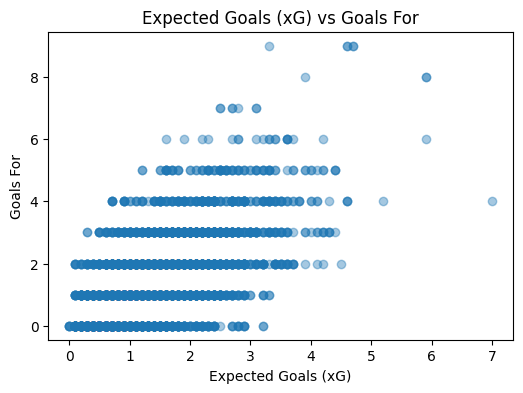

In [10]:
# -------------------------
# Relationship: xG vs Actual Goals
# -------------------------
plt.figure(figsize=(6,4))
plt.scatter(df_eda['expected_goals'], df_eda['goals_for'], alpha=0.4)
plt.title("Expected Goals (xG) vs Goals For")
plt.xlabel("Expected Goals (xG)")
plt.ylabel("Goals For")
plt.show()

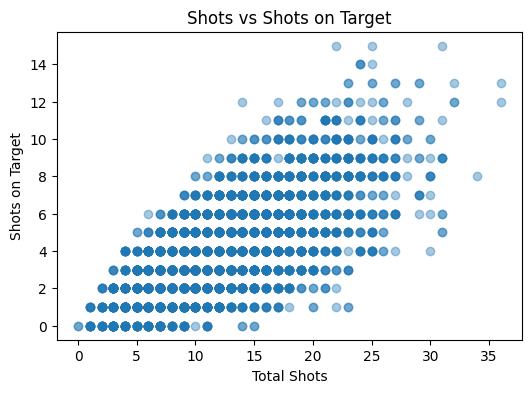

In [11]:
# -------------------------
# Shot Efficiency: Shots vs Shots on Target
# -------------------------
plt.figure(figsize=(6,4))
plt.scatter(df_eda['shots'], df_eda['shots_on_target'], alpha=0.4)
plt.title("Shots vs Shots on Target")
plt.xlabel("Total Shots")
plt.ylabel("Shots on Target")
plt.show()

### Distribution of Key Numerical Statistics
Let's visualize the distribution of some important numerical features like goals scored, shots, and possession to understand their typical ranges and spread.

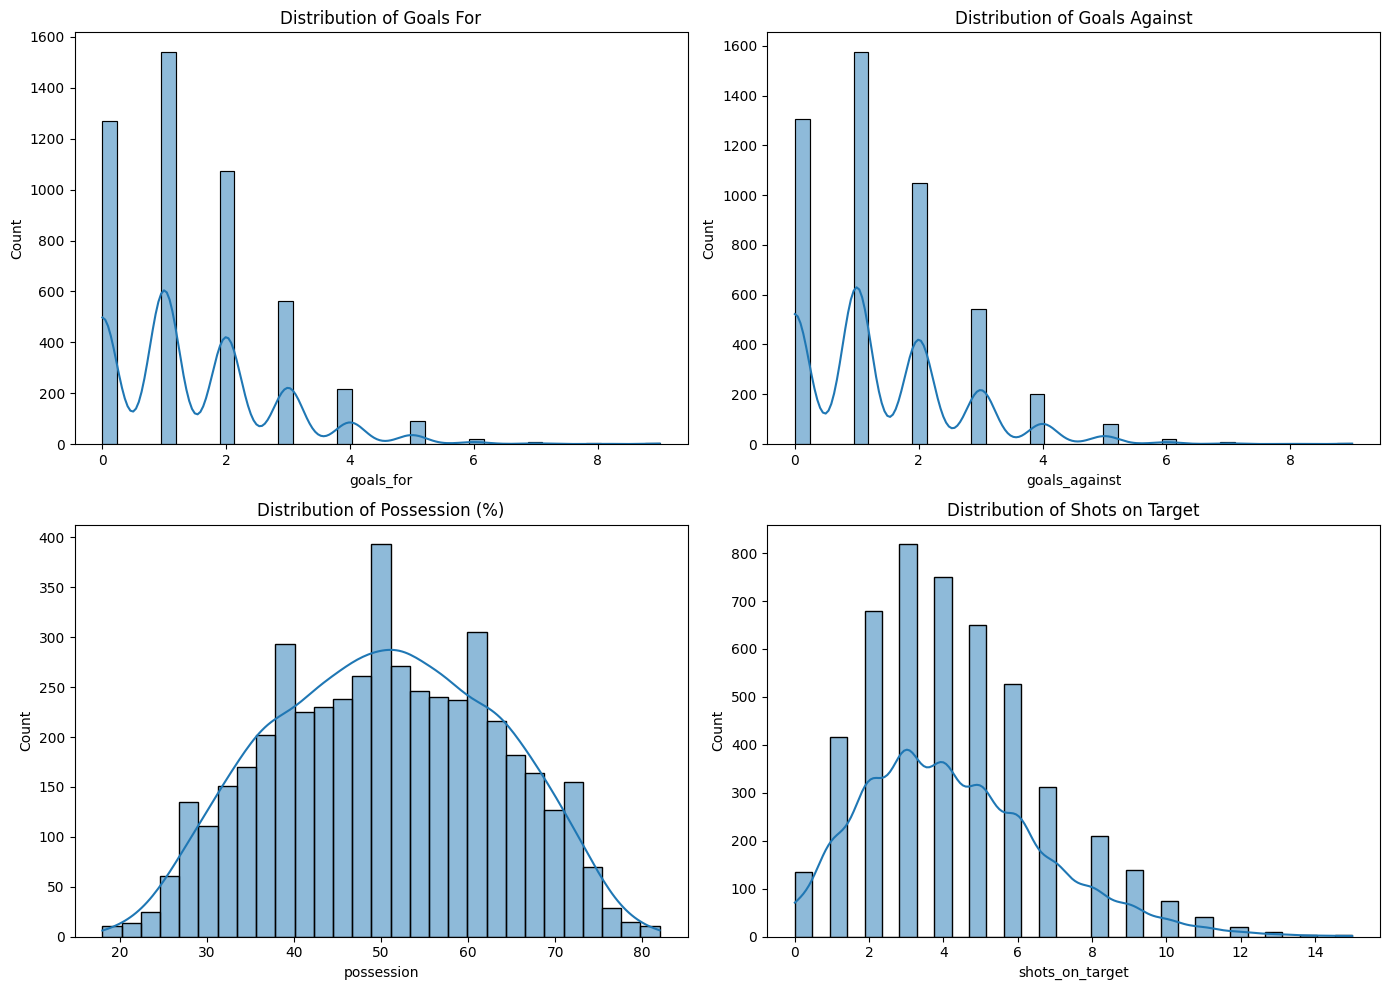

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for numerical feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

sns.histplot(df_eda['goals_for'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Goals For')

sns.histplot(df_eda['goals_against'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Goals Against')

sns.histplot(df_eda['possession'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Possession (%)')

sns.histplot(df_eda['shots_on_target'], kde=True, ax=axes[3])
axes[3].set_title('Distribution of Shots on Target')

plt.tight_layout()
plt.show()

### Correlation Heatmap of Numerical Features
Let's visualize the correlation between numerical features to identify highly correlated variables, which can be useful for feature selection or understanding relationships.

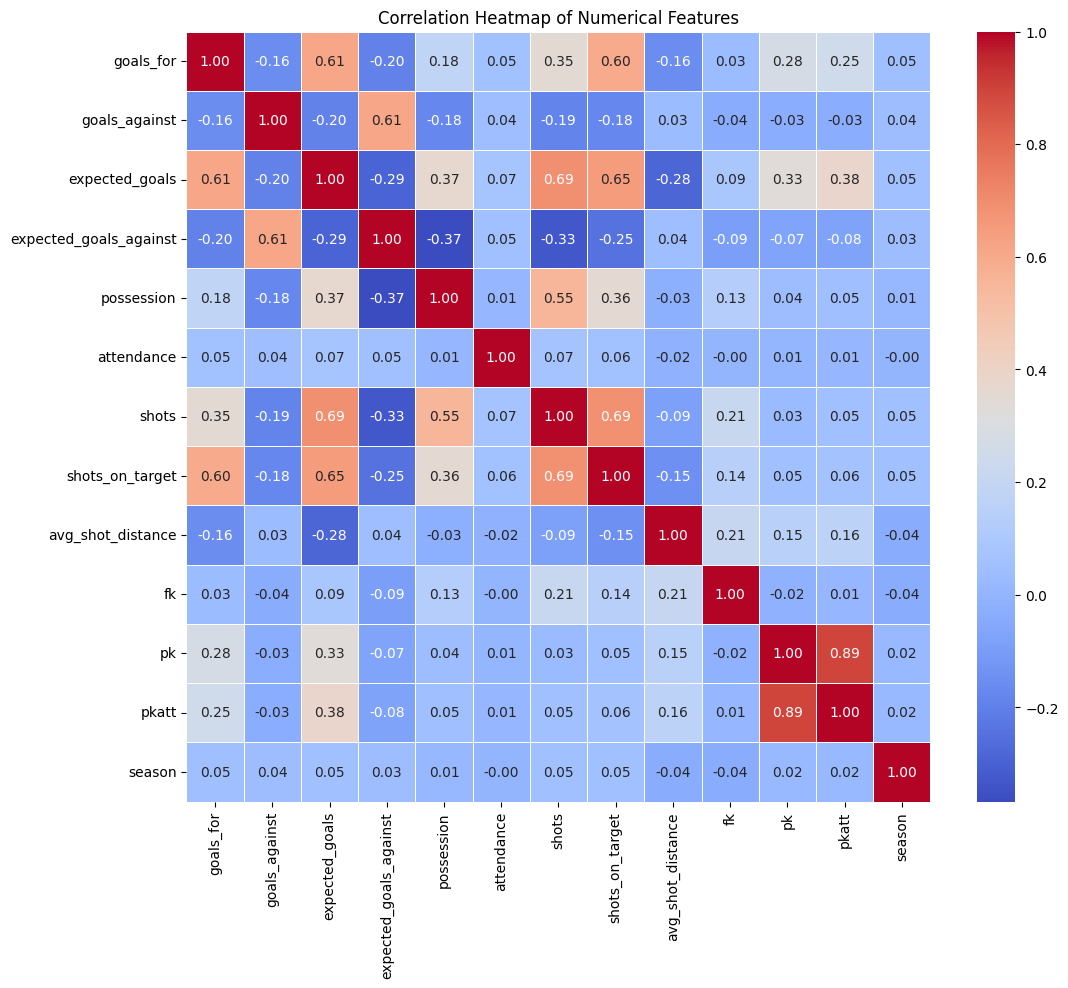

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation calculation
numerical_cols = df_eda.select_dtypes(include=['number']).columns
correlation_matrix = df_eda[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Venue Effect on Match Results
Let's see if playing at 'Home' or 'Away' significantly influences the match outcome.

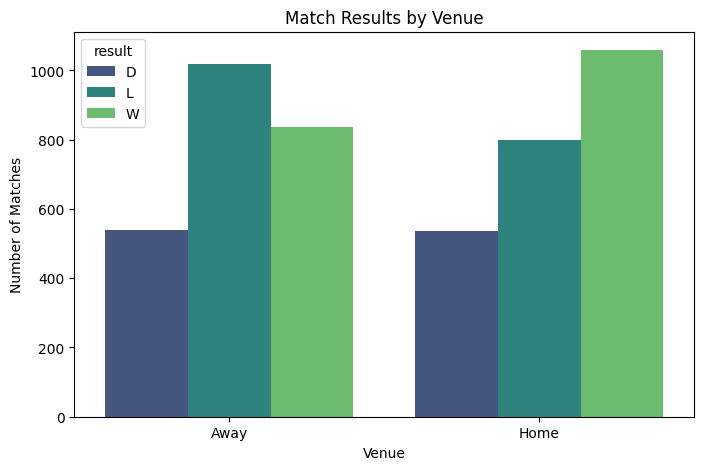

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df_eda, x='venue', hue='result', palette='viridis')
plt.title('Match Results by Venue')
plt.xlabel('Venue')
plt.ylabel('Number of Matches')
plt.show()

### Possession vs. Match Result
Is there a noticeable pattern between a team's possession percentage and the final match result?

/tmp/ipython-input-4140949456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='result', y='possession', palette='coolwarm')


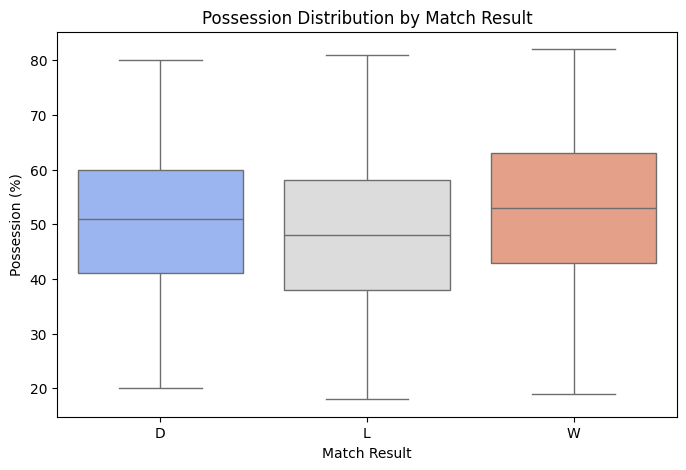

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_eda, x='result', y='possession', hue='result', palette='coolwarm', legend=False)
plt.title('Possession Distribution by Match Result')
plt.xlabel('Match Result')
plt.ylabel('Possession (%)')
plt.show()

In [12]:
import pandas as pd

#   Ensure correct ordering for rolling stats
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['team', 'date']).reset_index(drop=True)

#   Basic Feature: Goal Difference
data['goal_diff'] = data['goals_for'] - data['goals_against']

#   Points System from Result
data['points'] = data['result'].map({'W': 3, 'D': 1, 'L': 0})

#   Rolling Form Features (Last 5 matches)
data['rolling_goals_for_5'] = data.groupby('team')['goals_for'].rolling(5).mean().reset_index(level=0, drop=True)
data['rolling_goals_against_5'] = data.groupby('team')['goals_against'].rolling(5).mean().reset_index(level=0, drop=True)

# xG Difference Feature
data['xg_diff'] = data['expected_goals'] - data['expected_goals_against']
data['rolling_xg_diff_5'] = data.groupby('team')['xg_diff'].rolling(5).mean().reset_index(level=0, drop=True)

# Rolling Points (Momentum)
data['rolling_points_5'] = data.groupby('team')['points'].rolling(5).sum().reset_index(level=0, drop=True)

#   Venue Encoding
data['is_home'] = data['venue'].map({'Home': 1, 'Away': 0})

#   Remove unmatched first 4 games (no rolling history)
data = data.dropna(subset=[
    'rolling_goals_for_5',
    'rolling_goals_against_5',
    'rolling_xg_diff_5',
    'rolling_points_5'
]).reset_index(drop=True)

data.head()

,date,venue,result,goals_for,goals_against,opponent,expected_goals,expected_goals_against,possession,attendance,...,season,team,goal_diff,points,rolling_goals_for_5,rolling_goals_against_5,xg_diff,rolling_xg_diff_5,rolling_points_5,is_home
0,2019-09-15,Away,D,2,2,Watford,0.8,2.7,48,21360.0,...,2020,Arsenal,0,1,1.6,1.6,-1.9,-0.60,8.0,0
1,2019-09-22,Home,W,3,2,Aston Villa,2.4,1.5,58,60331.0,...,2020,Arsenal,1,3,2.0,2.0,0.9,-0.56,8.0,1
2,2019-09-30,Away,D,1,1,Manchester Utd,1.9,0.9,45,73201.0,...,2020,Arsenal,0,1,1.8,2.0,1.0,-0.22,6.0,0
3,2019-10-06,Home,W,1,0,Bournemouth,1.2,0.6,53,60326.0,...,2020,Arsenal,1,3,1.8,1.4,0.6,0.20,9.0,1
4,2019-10-21,Away,L,0,1,Sheffield Utd,1.0,0.9,67,30775.0,...,2020,Arsenal,-1,0,1.4,1.2,0.1,0.14,8.0,0


In [25]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Ensure y_train and y_test are numerically encoded for the model.
le = LabelEncoder()
# Fit the encoder on the entire training set's results to ensure consistent mapping
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test) # Use transform for the test set

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train_encoded) # Train with the updated X_train and encoded y_train

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred))

Accuracy: 0.5912698412698413
              precision    recall  f1-score   support

           0       0.34      0.20      0.25       164
           1       0.59      0.70      0.64       294
           2       0.67      0.70      0.68       298

    accuracy                           0.59       756
   macro avg       0.53      0.53      0.53       756
weighted avg       0.57      0.59      0.57       756



In [14]:
data['opp_rolling_goals_for_5'] = data.groupby('opponent')['rolling_goals_for_5'].transform('mean')
data['opp_rolling_goals_against_5'] = data.groupby('opponent')['rolling_goals_against_5'].transform('mean')
data['opp_rolling_points_5'] = data.groupby('opponent')['rolling_points_5'].transform('mean')

# Difference metrics — how much stronger/weaker a team is compared to the opponent
data['form_attack_diff'] = data['rolling_goals_for_5'] - data['opp_rolling_goals_against_5']
data['form_defense_diff'] = data['rolling_goals_against_5'] - data['opp_rolling_goals_for_5']
data['momentum_diff'] = data['rolling_points_5'] - data['opp_rolling_points_5']

# Drop any new NaNs
data = data.dropna(subset=[
    'form_attack_diff', 'form_defense_diff', 'momentum_diff'
]).reset_index(drop=True)

In [15]:
features = [
    'rolling_goals_for_5',
    'rolling_goals_against_5',
    'rolling_xg_diff_5',
    'rolling_points_5',
    'is_home',
    'form_attack_diff',
    'form_defense_diff',
    'momentum_diff'
]


train = data[data['date'] < '2023-07-01']
test = data[data['date'] >= '2023-07-01']
-
X_train = train[features]
y_train = train['result']
X_test = test[features]
y_test = test['result']

print("Feature matrix rebuilt successfully!")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

✅ Feature matrix rebuilt successfully!
Train shape: (3928, 8) Test shape: (756, 8)


🔥 Logistic Regression Model Accuracy: 61.77 %

📊 Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.33      0.02      0.03       164
           1       0.60      0.81      0.69       294
           2       0.65      0.76      0.70       298

    accuracy                           0.62       756
   macro avg       0.53      0.53      0.47       756
weighted avg       0.56      0.62      0.55       756



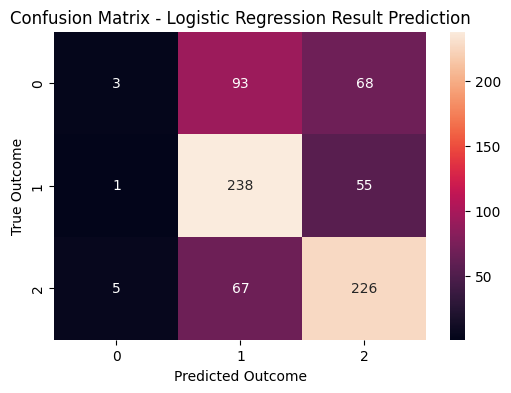

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model
print("🔥 Logistic Regression Model Accuracy:", round(accuracy_score(y_test_encoded, y_pred_log_reg)*100, 2), "%")
print("\n📊 Classification Report (Logistic Regression):\n", classification_report(y_test_encoded, y_pred_log_reg))

# Confusion Matrix for Logistic Regression
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_log_reg), annot=True, fmt="d",
            xticklabels=le.inverse_transform(log_reg_model.classes_),
            yticklabels=le.inverse_transform(log_reg_model.classes_))
plt.title("Confusion Matrix - Logistic Regression Result Prediction")
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()


### Comprehensive Model Performance Comparison

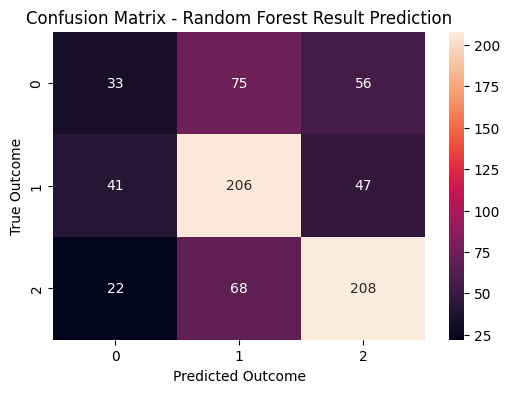

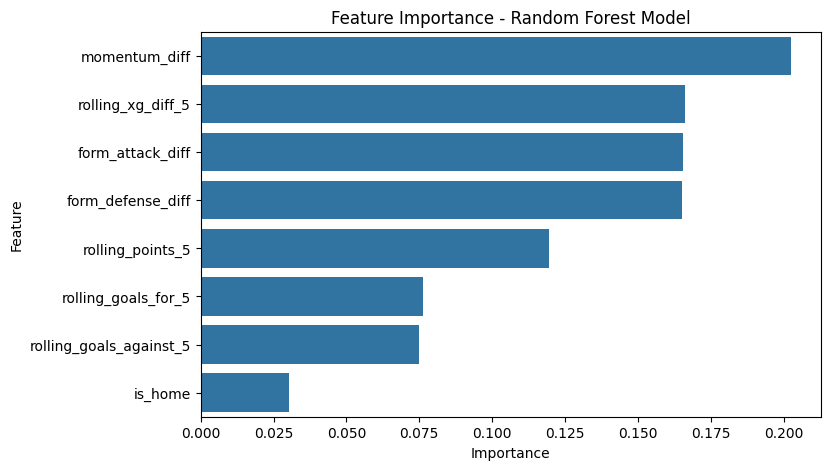

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming y_test_encoded and y_pred (from RandomForest) are available from previous runs
# Assuming 'features' list is also available

# Confusion Matrix for Random Forest
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt="d",
            xticklabels=le.inverse_transform(model.classes_), # Use LabelEncoder to get original labels
            yticklabels=le.inverse_transform(model.classes_))
plt.title("Confusion Matrix - Random Forest Result Prediction")
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()

# Feature Importance for Random Forest
importances_rf = model.feature_importances_
feat_imp_rf = pd.DataFrame({'Feature': features, 'Importance': importances_rf}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_rf)
plt.title("Feature Importance - Random Forest Model")
plt.show()

In [22]:
import pandas as pd

# Example match input
new_match = pd.DataFrame([
    {
    'rolling_goals_for_5': 2.1,        # Team’s avg goals in last 5 matches
    'rolling_goals_against_5': 0.8,    # Avg goals conceded
    'rolling_xg_diff_5': 0.6,          # Avg expected goals difference
    'rolling_points_5': 12,            # Total points in last 5 matches (form)
    'is_home': 1,                      # 1 = Home, 0 = Away
    'form_attack_diff': 0.7,           # Attack form vs opponent defense
    'form_defense_diff': -0.3,         # Defense form vs opponent attack
    'momentum_diff': 3                 # Points difference in form
    }
])

# Predict probabilities for each outcome
proba = model.predict_proba(new_match)[0]
classes = model.classes_

# Combine results nicely
prob_df = pd.DataFrame({
    'Outcome': le.inverse_transform(classes), # Use inverse_transform to get original labels
    'Probability': [round(p * 100, 2) for p in proba]
}).sort_values(by='Probability', ascending=False)

print(" Predicted Outcome Probabilities:")
print(prob_df.to_string(index=False))

predicted_outcome_encoded = model.predict(new_match)[0]
predicted_outcome = le.inverse_transform([predicted_outcome_encoded])[0]
print(f"\nPredicted Match Result: **{predicted_outcome}**")

 Predicted Outcome Probabilities:
Outcome  Probability
      W         57.0
      L         25.0
      D         18.0

Predicted Match Result: **W**


🔥 XGBoost Model Accuracy: 60.19 %

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.18      0.25       164
           1       0.60      0.73      0.66       294
           2       0.64      0.70      0.67       298

    accuracy                           0.60       756
   macro avg       0.55      0.54      0.53       756
weighted avg       0.58      0.60      0.58       756



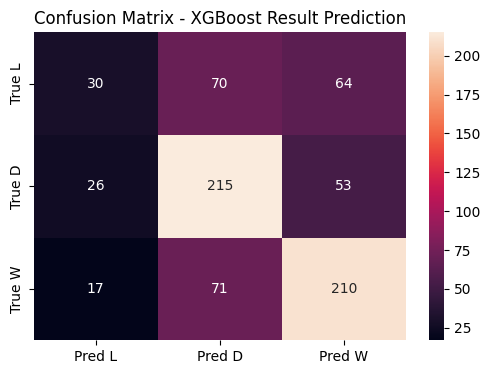

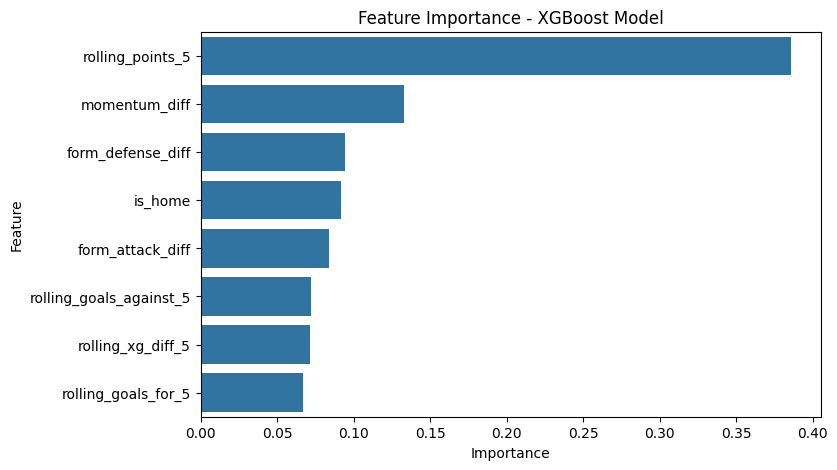

In [24]:
#   Install XGBoost if not already installed
!pip install xgboost --quiet

#   Import
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#   Define feature set (same as Random Forest)
features = [
    'rolling_goals_for_5',
    'rolling_goals_against_5',
    'rolling_xg_diff_5',
    'rolling_points_5',
    'is_home',
    'form_attack_diff',
    'form_defense_diff',
    'momentum_diff'
]

X_train = train[features]
X_test = test[features]
# Use the already encoded target variables
y_train = y_train_encoded
y_test = y_test_encoded

#   Build XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',
    num_class=3
)

#   Train
xgb_model.fit(X_train, y_train)

#   Predict
y_pred = xgb_model.predict(X_test)

#   Evaluation
print("🔥 XGBoost Model Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

#   Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=['Pred L','Pred D','Pred W'], # Assuming 0=D, 1=L, 2=W from LabelEncoder
            yticklabels=['True L','True D','True W'])
plt.title("Confusion Matrix - XGBoost Result Prediction")
plt.show()

#   Feature Importance
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("Feature Importance - XGBoost Model")
plt.show()

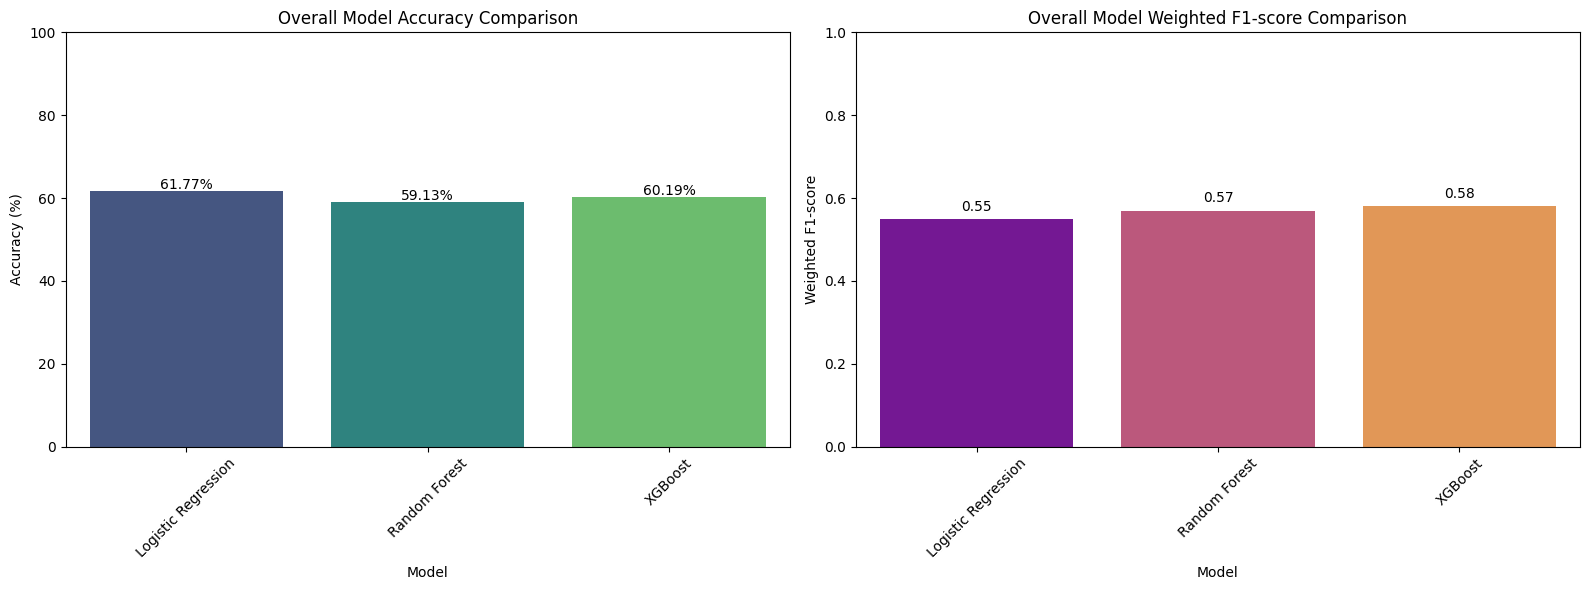

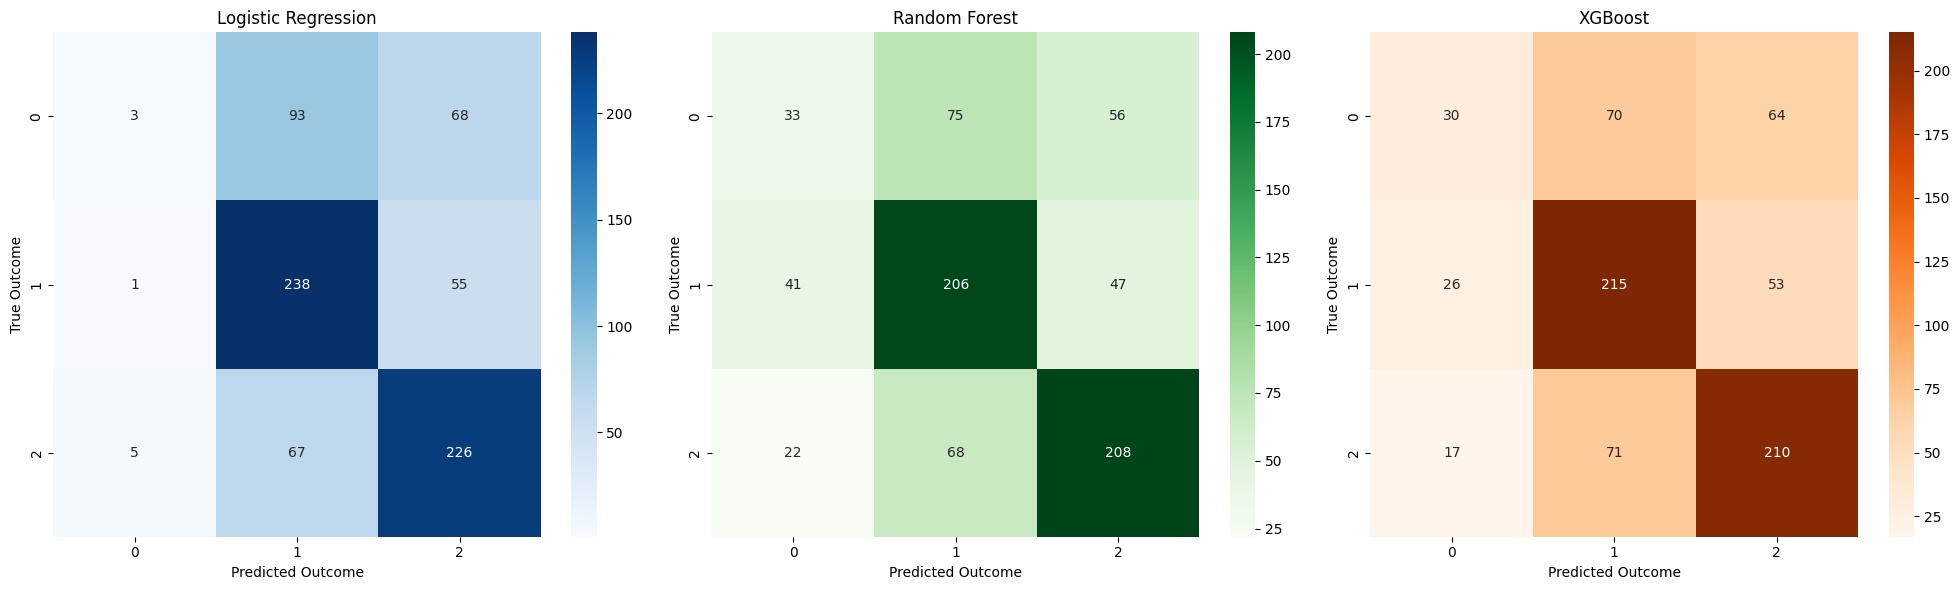

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Prepare Data for Comparison Charts ---

# Overall Accuracy Data
accuracy_data = [
    {'Model': 'Logistic Regression', 'Accuracy': 61.77},
    {'Model': 'Random Forest', 'Accuracy': 59.13},
    {'Model': 'XGBoost', 'Accuracy': 60.19}
]
accuracy_df = pd.DataFrame(accuracy_data)

# Weighted F1-score Data (extracted from previous classification reports)
weighted_f1_data = [
    {'Model': 'Logistic Regression', 'Weighted F1-score': 0.55},
    {'Model': 'Random Forest', 'Weighted F1-score': 0.57},
    {'Model': 'XGBoost', 'Weighted F1-score': 0.58}
]
weighted_f1_df = pd.DataFrame(weighted_f1_data)

# --- 2. Generate Bar Charts: Accuracy and Weighted F1-score ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for Accuracy
sns.barplot(x='Model', y='Accuracy', hue='Model', data=accuracy_df, palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Overall Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(0, 100)
axes[0].tick_params(axis='x', rotation=45)
for index, row in accuracy_df.iterrows():
    axes[0].text(index, row.Accuracy + 0.5, f"{row.Accuracy:.2f}%", color='black', ha="center")

# Bar chart for Weighted F1-score
sns.barplot(x='Model', y='Weighted F1-score', hue='Model', data=weighted_f1_df, palette='plasma', ax=axes[1], legend=False)
axes[1].set_title('Overall Model Weighted F1-score Comparison')
axes[1].set_ylabel('Weighted F1-score')
axes[1].set_ylim(0, 1.0)
axes[1].tick_params(axis='x', rotation=45)
for index, row in weighted_f1_df.iterrows():
    axes[1].text(index, row['Weighted F1-score'] + 0.02, f"{row['Weighted F1-score']:.2f}", color='black', ha="center")

plt.tight_layout()
plt.show()


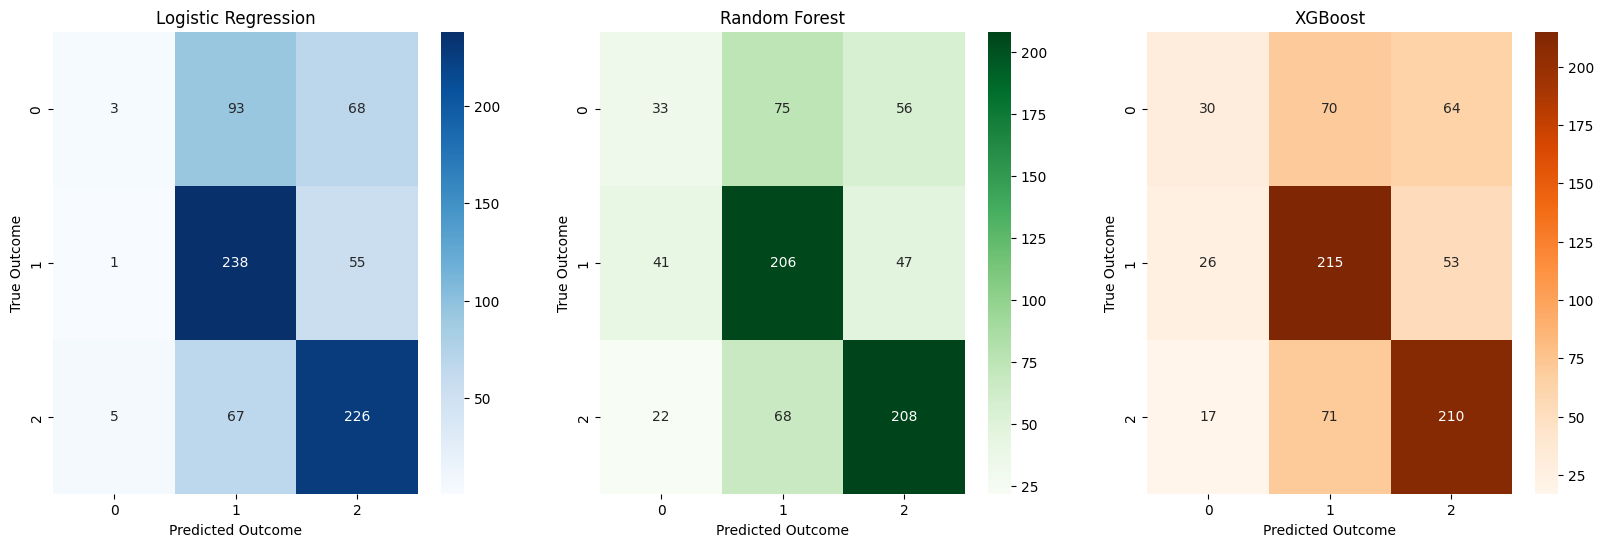

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
# --- 3. Generate Side-by-Side Confusion Matrices ---

# Retrieve predictions from previously run cells
# For Random Forest: y_pred is already defined
# For Logistic Regression: y_pred_log_reg is already defined
# For XGBoost: Assuming y_pred from the last run of xgb_model.predict(X_test) is available as y_pred_xgb
# If not, let's re-predict for XGBoost for consistency (using the last trained xgb_model)
y_pred_xgb = xgb_model.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_log_reg), annot=True, fmt="d",
            xticklabels=le.inverse_transform(log_reg_model.classes_),
            yticklabels=le.inverse_transform(log_reg_model.classes_), cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted Outcome')
axes[0].set_ylabel('True Outcome')

# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), annot=True, fmt="d",
            xticklabels=le.inverse_transform(model.classes_),
            yticklabels=le.inverse_transform(model.classes_), cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted Outcome')
axes[1].set_ylabel('True Outcome')

# XGBoost Confusion Matrix
sns.heatmap(confusion_matrix(y_test_encoded, y_pred_xgb), annot=True, fmt="d",
            xticklabels=le.inverse_transform(xgb_model.classes_),
            yticklabels=le.inverse_transform(xgb_model.classes_), cmap='Oranges', ax=axes[2])
axes[2].set_title('XGBoost')
axes[2].set_xlabel('Predicted Outcome')
axes[2].set_ylabel('True Outcome')


plt.show()

### Overall Model Comparison: Accuracy, Precision, Recall, and F1-score

Below is a consolidated view of the performance metrics for each model. Precision, Recall (Sensitivity), and F1-score are presented as weighted averages, which account for class imbalance.

| Metric              | Logistic Regression | Random Forest | XGBoost |
| :------------------ | :------------------ | :------------ | :------ |
| **Accuracy**        | 61.77%              | 59.13%        | 60.19%  |
| **Weighted Precision** | 0.56                | 0.57          | 0.58    |
| **Weighted Recall**    | 0.62                | 0.59          | 0.60    |
| **Weighted F1-score**  | 0.55                | 0.57          | 0.58    |

---

#### Per-Class Metrics Comparison
To understand performance on individual outcomes (Draw, Lose, Win), here's a breakdown of Precision, Recall, and F1-score for each class:

**Logistic Regression:**
| Class | Precision | Recall | F1-score |
| :---- | :-------- | :----- | :------- |
| Draw  | 0.33      | 0.02   | 0.03     |
| Lose  | 0.60      | 0.81   | 0.69     |
| Win   | 0.65      | 0.76   | 0.70     |

**Random Forest:**
| Class | Precision | Recall | F1-score |
| :---- | :-------- | :----- | :------- |
| Draw  | 0.34      | 0.20   | 0.25     |
| Lose  | 0.59      | 0.70   | 0.64     |
| Win   | 0.67      | 0.70   | 0.68     |

**XGBoost:**
| Class | Precision | Recall | F1-score |
| :---- | :-------- | :----- | :------- |
| Draw  | 0.41      | 0.18   | 0.25     |
| Lose  | 0.60      | 0.73   | 0.66     |
| Win   | 0.64      | 0.70   | 0.67     |

---

**Key Takeaways:**

*   **Accuracy vs. Weighted F1-score:** While Logistic Regression shows the highest overall accuracy, its weighted F1-score is the lowest, indicating that its high accuracy doesn't translate to balanced performance across all classes, particularly due to its poor handling of 'Draw' outcomes.
*   **'Draw' Prediction Challenge:** All models consistently struggle to predict 'Draws' effectively, as evidenced by their low recall and F1-scores for this class. Logistic Regression is exceptionally poor in this regard.
*   **Balance vs. Overall Performance:** Random Forest and XGBoost offer a more balanced performance across the 'Lose' and 'Win' classes, and a slightly better (though still limited) ability to predict 'Draws' compared to Logistic Regression. XGBoost marginally outperforms Random Forest in weighted F1-score and slightly in accuracy.

This comparison highlights the importance of looking beyond just overall accuracy when evaluating multi-class classification models, especially with class imbalances.